**Rozdział 11. Uczenie głębokich sieci neuronowych**

_Notatnik ten zawiera przykładowy kod i rozwiązania ćwiczeń opisane w rozdziale 11._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Uruchom w Google Colab (wersja angielska)</a>
  </td>
</table>

# Konfiguracja

Importujmy najpierw kilka popularnych modułów, upewnijmy się, że będą wstawiane wykresy MatplotLib, a także przygotujmy funkcję zapisującą rysunki. Sprawdzimy także, czy jest zainstalowane środowisko Python 3.5 lub nowsze (możliwe, że kod będzie działał w środowisku Python 2.x, zostało ono jednak porzucone, dlatego zalecamy korzystanie ze środowiska Python 3), a także biblioteka Scikit-Learn 0.20 lub nowsza i TensorFlow 2.0 lub nowszy.

In [1]:
# Wymagane środowisko Python ≥3.5
import sys
assert sys.version_info >= (3, 5)

# Wymagana biblioteka Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version istnieje jedynie w środowisku Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# Wymagany moduł TensorFlow ≥2.0
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Importuje standardowe biblioteki
import numpy as np
import os

# Aby wyniki uzyskiwane w tym notatniku były odtwarzalne
np.random.seed(42)

# Do rysowania ładnych wykresów
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ścieżka zapisywania rysunków
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "R11"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "rysunki", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Zapisywanie rysunku", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

TensorFlow 2.x selected.


# Problem zanikających/eksplodujących gradientów

In [0]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Zapisywanie rysunku r_11_1


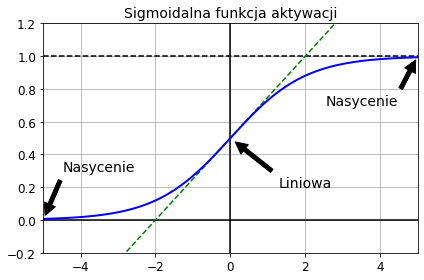

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Nasycenie', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Nasycenie', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Liniowa', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoidalna funkcja aktywacji", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("r_11_1")
plt.show()

## Inicjalizacja Xaviera i He

In [4]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'Identity',
 'Initializer',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'serialize',
 'zeros']

In [5]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [6]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## Nienasycające funkcje aktywacji

### Przeciekająca funkcja ReLU

In [0]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Zapisywanie rysunku r_11_2


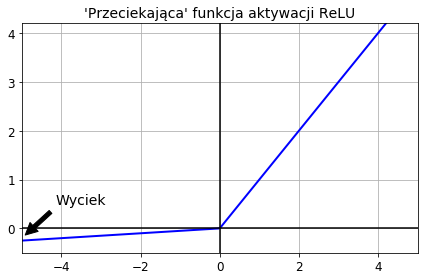

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Wyciek', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("'Przeciekająca' funkcja aktywacji ReLU", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("r_11_2")
plt.show()

In [9]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'tanh']

In [10]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

Wyuczmy sieć neuronową wobec zbioru danych MNIST wykorzystując przeciekającą funkcję ReLU:

In [11]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [0]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [14]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 112us/sample - loss: 1.2810 - accuracy: 0.6205 - val_loss: 0.8869 - val_accuracy: 0.7160
Epoch 2/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.7952 - accuracy: 0.7368 - val_loss: 0.7132 - val_accuracy: 0.7626
Epoch 3/10
55000/55000 [==============================] - 4s 79us/sample - loss: 0.6817 - accuracy: 0.7725 - val_loss: 0.6385 - val_accuracy: 0.7896
Epoch 4/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.6219 - accuracy: 0.7941 - val_loss: 0.5931 - val_accuracy: 0.8016
Epoch 5/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.5829 - accuracy: 0.8074 - val_loss: 0.5607 - val_accuracy: 0.8166
Epoch 6/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.5552 - accuracy: 0.8173 - val_loss: 0.5354 - val_accuracy: 0.8240
Epoch 7/10
55000/55000 [==============================] 

Sprawdźmy teraz funkcję PReLU:

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [0]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [17]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 89us/sample - loss: 1.3452 - accuracy: 0.6203 - val_loss: 0.9241 - val_accuracy: 0.7170
Epoch 2/10
55000/55000 [==============================] - 5s 83us/sample - loss: 0.8196 - accuracy: 0.7364 - val_loss: 0.7314 - val_accuracy: 0.7602
Epoch 3/10
55000/55000 [==============================] - 5s 83us/sample - loss: 0.6970 - accuracy: 0.7701 - val_loss: 0.6517 - val_accuracy: 0.7876
Epoch 4/10
55000/55000 [==============================] - 5s 88us/sample - loss: 0.6333 - accuracy: 0.7915 - val_loss: 0.6032 - val_accuracy: 0.8056
Epoch 5/10
55000/55000 [==============================] - 5s 88us/sample - loss: 0.5917 - accuracy: 0.8049 - val_loss: 0.5689 - val_accuracy: 0.8160
Epoch 6/10
55000/55000 [==============================] - 5s 91us/sample - loss: 0.5619 - accuracy: 0.8143 - val_loss: 0.5417 - val_accuracy: 0.8224
Epoch 7/10
55000/55000 [==============================] -

### Funkcja aktywacji ELU

In [0]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Zapisywanie rysunku r_11_3


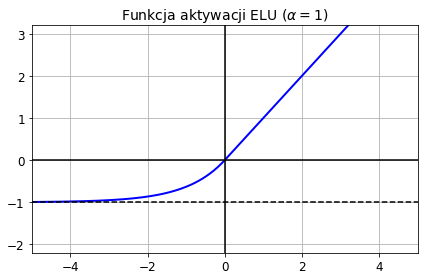

In [19]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"Funkcja aktywacji ELU ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("r_11_3")
plt.show()

Implementacja funkcji ELU w module TensorFlow jest banalna; wystarczy określić funkcję aktywacji podczas tworzenia każdej warstwy:

In [20]:
keras.layers.Dense(10, activation="elu")

### Funkcja SELU

Ta funkcja aktywacji została opisana w tej [znakomitej publikacji](https://arxiv.org/pdf/1706.02515.pdf) autorstwa Güntera Klambauera, Thomasa Unterthinera i Andreasa Mayra, która ukazała się w czerwcu 2017 roku. W czasie uczenie sieć neuronowa składająca się wyłącznie ze stosu warstw gęstych wykorzystujących funkcję aktywacji SELU i inicjalizację LeCuna przeprowadza proces samonormalizacji: wyjście każdej warstwy będzie przechowywać taką samą średnią i wariancję w czasie uczenia, co rozwiązuje problem zanikających/eksplodujących gradientów. W konsekwencji ta funkcja aktywacji osiąga znacznie lepsze rezultaty od wcześniejszych funkcji aktywacji w tego typu sieciach neuronowych, dlatego naprawdę warto ją wypróbować. Niestety, własność samonormalizacji funkcji aktywacji SELU jest bardzo wrażliwa: nie można korzystać z regularyzacji ℓ<sub>1</sub> i ℓ<sub>2</sub>, standardowego porzucania, normalizacji typu max-norm, połączeń pomijających ani innych topologii niesekwencyjnych (zatem sieci rekurencyjne nie będą samornormalizowane). W praktyce jednak sprawdza się ona całkiem dobrze w sekwencyjnych sieciach splotowych. Bez samonormalizacji funkcja SELU nie osiąga lepszych wyników od pozostałych funkcji aktywacji.

In [0]:
from scipy.special import erfc

# zmienne alpha i scale służą do samonormalizacji ze średnią 0 i odchyleniem standardowym 1
# (zob. równanie 14. we wspomnianej publikacji):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [0]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Zapisywanie rysunku funkcja_SELU


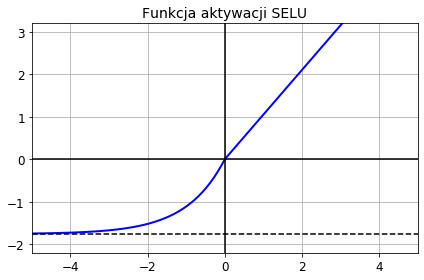

In [23]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("Funkcja aktywacji SELU", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("funkcja_SELU")
plt.show()

Domyślnie hiperparametry funkcji SELU (`scale` i `alpha`) zostają dostrojone w taki sposób, aby średnia na wyjściu każdego neuronu była bliska 0, a odchylenie standardowe pozostawało zbliżone do 1 (przy założeniu, że również wejścia są standaryzowane do średniej 0 i odchylenia standardwoego 1). Dzięki tej funkcji aktywacji nawet tysiącwarstwowa sieć neuronowa zachowuje mniej więcej średnią 0 i odchylenie standardowe 1 we wszystkich warstwach, co pozwala uniknąć kwestii eksplodujących/zanikających gradientów:

In [24]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standaryzowane wejścia
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # inicjalizacja LeCuna
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("warstwa numer {}: średnia {:.2f}, odchylenie standardowe {:.2f}".format(layer, means, stds))

warstwa numer 0: średnia -0.00, odchylenie standardowe 1.00
warstwa numer 100: średnia 0.02, odchylenie standardowe 0.96
warstwa numer 200: średnia 0.01, odchylenie standardowe 0.90
warstwa numer 300: średnia -0.02, odchylenie standardowe 0.92
warstwa numer 400: średnia 0.05, odchylenie standardowe 0.89
warstwa numer 500: średnia 0.01, odchylenie standardowe 0.93
warstwa numer 600: średnia 0.02, odchylenie standardowe 0.92
warstwa numer 700: średnia -0.02, odchylenie standardowe 0.90
warstwa numer 800: średnia 0.05, odchylenie standardowe 0.83
warstwa numer 900: średnia 0.02, odchylenie standardowe 1.00


Korzystanie z funkcji SELU jest łatwe:

In [25]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

Stwórzmy sieć neuronową dla zestawu danych Fashion MNIST, zawierającą 100 warstw ukrytych i funkcję aktywacji SELU:

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [0]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

Wytrenujmy ją. Nie zapomnij przeskalować danych wejściowych do średniej 0 i odchylenia standardowego 1:

In [0]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [30]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 19s 340us/sample - loss: 1.1330 - accuracy: 0.5692 - val_loss: 0.8073 - val_accuracy: 0.6728
Epoch 2/5
55000/55000 [==============================] - 16s 295us/sample - loss: 0.7538 - accuracy: 0.7252 - val_loss: 0.6410 - val_accuracy: 0.7704
Epoch 3/5
55000/55000 [==============================] - 16s 292us/sample - loss: 0.6290 - accuracy: 0.7715 - val_loss: 0.6406 - val_accuracy: 0.7576
Epoch 4/5
55000/55000 [==============================] - 16s 295us/sample - loss: 0.5535 - accuracy: 0.8003 - val_loss: 0.5332 - val_accuracy: 0.8164
Epoch 5/5
55000/55000 [==============================] - 16s 296us/sample - loss: 0.5000 - accuracy: 0.8245 - val_loss: 0.4950 - val_accuracy: 0.8204


Spójrzmy, co się stanie, jeśli spróbujemy skorzystać z funkcji aktywacji ReLU:

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [0]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [34]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 18s 333us/sample - loss: 1.7955 - accuracy: 0.2735 - val_loss: 1.2961 - val_accuracy: 0.4698
Epoch 2/5
55000/55000 [==============================] - 17s 306us/sample - loss: 1.1094 - accuracy: 0.5339 - val_loss: 1.1513 - val_accuracy: 0.4930
Epoch 3/5
55000/55000 [==============================] - 16s 295us/sample - loss: 0.9205 - accuracy: 0.6300 - val_loss: 0.8929 - val_accuracy: 0.6450
Epoch 4/5
55000/55000 [==============================] - 16s 298us/sample - loss: 0.8414 - accuracy: 0.6635 - val_loss: 0.9134 - val_accuracy: 0.6324
Epoch 5/5
55000/55000 [==============================] - 16s 296us/sample - loss: 0.8001 - accuracy: 0.6894 - val_loss: 0.6861 - val_accuracy: 0.7500


Całkiem kiepsko, dopadł nas problem zanikających/eksplodujących gradientów.

# Normalizacja wsadowa

In [0]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [36]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_212 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_213 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_214 (Dense)            (None, 10)               

In [37]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [38]:
bn1.updates

[<tf.Operation 'cond/Identity' type=Identity>,
 <tf.Operation 'cond_1/Identity' type=Identity>]

In [0]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [40]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 7s 125us/sample - loss: 0.8761 - accuracy: 0.7124 - val_loss: 0.5508 - val_accuracy: 0.8222
Epoch 2/10
55000/55000 [==============================] - 6s 114us/sample - loss: 0.5737 - accuracy: 0.8038 - val_loss: 0.4723 - val_accuracy: 0.8460
Epoch 3/10
55000/55000 [==============================] - 6s 115us/sample - loss: 0.5142 - accuracy: 0.8230 - val_loss: 0.4376 - val_accuracy: 0.8570
Epoch 4/10
55000/55000 [==============================] - 7s 118us/sample - loss: 0.4825 - accuracy: 0.8331 - val_loss: 0.4135 - val_accuracy: 0.8634
Epoch 5/10
55000/55000 [==============================] - 6s 115us/sample - loss: 0.4571 - accuracy: 0.8414 - val_loss: 0.3991 - val_accuracy: 0.8652
Epoch 6/10
55000/55000 [==============================] - 6s 115us/sample - loss: 0.4431 - accuracy: 0.8457 - val_loss: 0.3871 - val_accuracy: 0.8702
Epoch 7/10
55000/55000 [===========================

Czasami wprowadzanie normalizacji wsadowej przed funkcją aktywacji sprawdza się lepiej (kwestia ta ciągle jest tematem dyskusji). Ponadto warstwa poprzedzająca warstwę `BatchNormalization` nie wymaga członów obciążenia, ponieważ zawiera je warstwa `BatchNormalization`, zatem aby uniknąć marnotrawienia parametrów, możesz wyznaczyć `use_bias=False` podczas tworzenia tych warstw:

In [0]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [0]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [43]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 7s 123us/sample - loss: 1.0334 - accuracy: 0.6755 - val_loss: 0.6738 - val_accuracy: 0.7832
Epoch 2/10
55000/55000 [==============================] - 6s 117us/sample - loss: 0.6761 - accuracy: 0.7820 - val_loss: 0.5562 - val_accuracy: 0.8194
Epoch 3/10
55000/55000 [==============================] - 6s 115us/sample - loss: 0.5929 - accuracy: 0.8056 - val_loss: 0.5005 - val_accuracy: 0.8368
Epoch 4/10
55000/55000 [==============================] - 6s 115us/sample - loss: 0.5467 - accuracy: 0.8161 - val_loss: 0.4652 - val_accuracy: 0.8452
Epoch 5/10
55000/55000 [==============================] - 6s 115us/sample - loss: 0.5114 - accuracy: 0.8268 - val_loss: 0.4427 - val_accuracy: 0.8520
Epoch 6/10
55000/55000 [==============================] - 6s 115us/sample - loss: 0.4903 - accuracy: 0.8333 - val_loss: 0.4264 - val_accuracy: 0.8544
Epoch 7/10
55000/55000 [===========================

## Obcinanie gradientu

Wszystkie optymalizatory Keras przyjmują argumenty `clipnorm` albo `clipvalue`:

In [0]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [0]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

## Wielokrotne stosowanie gotowych warstw

## Wielokrotne stosowanie modelu Keras

Podzielmy zestaw danych Fashion MNIST na dwa podzbiory:
* `X_train_A`: wszystkie elementy ze wszystkich klas oprócz sandałów i koszulek (klas 5. i 6.).
* `X_train_B`: znacznie mniejszy zbiór uczący zawierający jedynie 200 pierwszych obrazów sandałów i koszulek.

W taki sam sposób rozdzielamy zbiór walidacyjny i testowy, ale nie ograniczamy w nich liczby obrazów.

Wytrenujemy model na zestawie A (zadanie klasyfikacji na podstawie ośmiu klas) i spróbujemy go wykorzystać do przetworzenia zestawu B (klasyfikacja binarna). Mamy nadzieję, że przeniesiemy odrobinę wiedzy z zadania A do zadania B, ponieważ klasy ze zbioru A (tenisówki, trzewiki, płaszcze, bluzy itd.) są niejako podobne do klas z zestawu B (sandałów i koszulek). Korzystamy jednak z warstw `Dense`, więc zostaną ponownie wykorzystane jedynie wzorce pojawiające się w tych samym miejscu (z kolei warstwy splotowe przenoszą wiedzę znacznie lepiej, ponieważ poznane wzorce będą wykrywane w dowolnym miejscu obrazu, o czym przekonamy się podczas omawiania sieci splotowych).

In [0]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandały albo koszulki
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # indeksy klas 7., 8., 9. powinny zostać przeniesione do 5., 6., 7.
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # zadanie klasyfikacji binarnej: czy jest to koszulka (klasa 6.)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [47]:
X_train_A.shape

(43986, 28, 28)

In [48]:
X_train_B.shape

(200, 28, 28)

In [49]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [50]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

In [0]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [0]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [54]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Train on 43986 samples, validate on 4014 samples
Epoch 1/20
43986/43986 [==============================] - 4s 90us/sample - loss: 0.5902 - accuracy: 0.8131 - val_loss: 0.3785 - val_accuracy: 0.8692
Epoch 2/20
43986/43986 [==============================] - 4s 83us/sample - loss: 0.3518 - accuracy: 0.8784 - val_loss: 0.3372 - val_accuracy: 0.8842
Epoch 3/20
43986/43986 [==============================] - 4s 83us/sample - loss: 0.3163 - accuracy: 0.8895 - val_loss: 0.3016 - val_accuracy: 0.8959
Epoch 4/20
43986/43986 [==============================] - 4s 82us/sample - loss: 0.2969 - accuracy: 0.8974 - val_loss: 0.2911 - val_accuracy: 0.9018
Epoch 5/20
43986/43986 [==============================] - 4s 84us/sample - loss: 0.2832 - accuracy: 0.9025 - val_loss: 0.2816 - val_accuracy: 0.9013
Epoch 6/20
43986/43986 [==============================] - 4s 87us/sample - loss: 0.2726 - accuracy: 0.9067 - val_loss: 0.2738 - val_accuracy: 0.9078
Epoch 7/20
43986/43986 [==============================] -

In [0]:
model_A.save("moj_model_A.h5")

In [0]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [0]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [58]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/20
200/200 [==============================] - 1s 4ms/sample - loss: 0.9509 - accuracy: 0.4800 - val_loss: 0.6533 - val_accuracy: 0.5568
Epoch 2/20
200/200 [==============================] - 0s 474us/sample - loss: 0.5837 - accuracy: 0.7100 - val_loss: 0.4825 - val_accuracy: 0.8479
Epoch 3/20
200/200 [==============================] - 0s 508us/sample - loss: 0.4527 - accuracy: 0.8750 - val_loss: 0.4097 - val_accuracy: 0.8945
Epoch 4/20
200/200 [==============================] - 0s 476us/sample - loss: 0.3869 - accuracy: 0.9050 - val_loss: 0.3630 - val_accuracy: 0.9209
Epoch 5/20
200/200 [==============================] - 0s 461us/sample - loss: 0.3404 - accuracy: 0.9300 - val_loss: 0.3302 - val_accuracy: 0.9280
Epoch 6/20
200/200 [==============================] - 0s 442us/sample - loss: 0.3073 - accuracy: 0.9350 - val_loss: 0.3026 - val_accuracy: 0.9381
Epoch 7/20
200/200 [==============================] - 0s 488us/sample - loss: 0.

In [59]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
dense_215 (Dense)            (None, 300)               235200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
activation (Activation)      (None, 300)               0         
_________________________________________________________________
dense_216 (Dense)            (None, 100)               30000     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)              

In [0]:
model_A = keras.models.load_model("moj_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [0]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [0]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

In [63]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/4
200/200 [==============================] - 0s 2ms/sample - loss: 0.5632 - accuracy: 0.6650 - val_loss: 0.5685 - val_accuracy: 0.6531
Epoch 2/4
200/200 [==============================] - 0s 433us/sample - loss: 0.5262 - accuracy: 0.7150 - val_loss: 0.5352 - val_accuracy: 0.6947
Epoch 3/4
200/200 [==============================] - 0s 435us/sample - loss: 0.4936 - accuracy: 0.7400 - val_loss: 0.5054 - val_accuracy: 0.7211
Epoch 4/4
200/200 [==============================] - 0s 435us/sample - loss: 0.4643 - accuracy: 0.7550 - val_loss: 0.4788 - val_accuracy: 0.7383
Train on 200 samples, validate on 986 samples
Epoch 1/16
200/200 [==============================] - 0s 2ms/sample - loss: 0.3875 - accuracy: 0.8150 - val_loss: 0.3366 - val_accuracy: 0.8671
Epoch 2/16
200/200 [==============================] - 0s 477us/sample - loss: 0.2708 - accuracy: 0.9300 - val_loss: 0.2614 - val_accuracy: 0.9270
Epoch 3/16
200/200 [====================

Jaki jest więc ostateczny werdykt?

In [64]:
model_B.evaluate(X_test_B, y_test_B)

2000/2000 [==============================] - 0s 77us/sample - loss: 0.1426 - accuracy: 0.9695


[0.14263125455379486, 0.9695]

In [65]:
model_B_on_A.evaluate(X_test_B, y_test_B)

2000/2000 [==============================] - 0s 61us/sample - loss: 0.0697 - accuracy: 0.9925


[0.06965963751077651, 0.9925]

Świetnie! Udało nam się przenieść wiedzę: współczynnik błędu zmalał niemal czterokrotnie!

In [66]:
(100 - 97.05) / (100 - 99.25)

3.933333333333337

# Szybsze optymalizatory

## Optymalizacja momentum

In [0]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

## Algorytm Nesterova

In [0]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

## AdaGrad

In [0]:
optimizer = keras.optimizers.Adagrad(lr=0.001)

## RMSProp

In [0]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

## Optymalizacja Adam

In [0]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

## Optymalizacja Adamax

In [0]:
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)

## Optymalizacja Nadam

In [0]:
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

## Harmonogramowanie współczynnika uczenia

### Harmonogramowanie potęgowe

```lr = lr0 / (1 + kroki / s)**c```
* Keras wykorzystuje `c=1` i `s = 1 / rozkład`

In [0]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

In [0]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [76]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 5s 83us/sample - loss: 0.4842 - accuracy: 0.8320 - val_loss: 0.4166 - val_accuracy: 0.8566
Epoch 2/25
55000/55000 [==============================] - 4s 76us/sample - loss: 0.3788 - accuracy: 0.8644 - val_loss: 0.3779 - val_accuracy: 0.8680
Epoch 3/25
55000/55000 [==============================] - 4s 77us/sample - loss: 0.3460 - accuracy: 0.8769 - val_loss: 0.3691 - val_accuracy: 0.8714
Epoch 4/25
55000/55000 [==============================] - 4s 81us/sample - loss: 0.3251 - accuracy: 0.8839 - val_loss: 0.3534 - val_accuracy: 0.8766
Epoch 5/25
55000/55000 [==============================] - 4s 77us/sample - loss: 0.3091 - accuracy: 0.8898 - val_loss: 0.3456 - val_accuracy: 0.8804
Epoch 6/25
55000/55000 [==============================] - 4s 80us/sample - loss: 0.2969 - accuracy: 0.8936 - val_loss: 0.3435 - val_accuracy: 0.8796
Epoch 7/25
55000/55000 [==============================] -

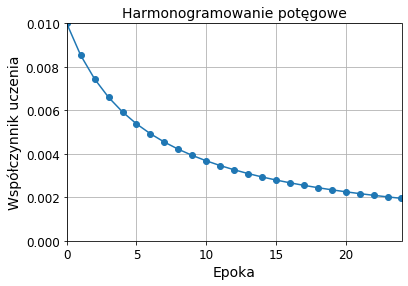

In [77]:
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoka")
plt.ylabel("Współczynnik uczenia")
plt.title("Harmonogramowanie potęgowe", fontsize=14)
plt.grid(True)
plt.show()

### Harmonogramowanie wykładnicze

```lr = lr0 * 0.1**(epoka / s)```

In [0]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [0]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [0]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [81]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 6s 115us/sample - loss: 0.8422 - accuracy: 0.7567 - val_loss: 0.8395 - val_accuracy: 0.6842
Epoch 2/25
55000/55000 [==============================] - 6s 104us/sample - loss: 0.7013 - accuracy: 0.7907 - val_loss: 0.7395 - val_accuracy: 0.8174
Epoch 3/25
55000/55000 [==============================] - 6s 104us/sample - loss: 0.6379 - accuracy: 0.8095 - val_loss: 0.9067 - val_accuracy: 0.6936
Epoch 4/25
55000/55000 [==============================] - 6s 103us/sample - loss: 0.5595 - accuracy: 0.8283 - val_loss: 0.6171 - val_accuracy: 0.8290
Epoch 5/25
55000/55000 [==============================] - 6s 104us/sample - loss: 0.4892 - accuracy: 0.8473 - val_loss: 0.5682 - val_accuracy: 0.8452
Epoch 6/25
55000/55000 [==============================] - 6s 104us/sample - loss: 0.4572 - accuracy: 0.8564 - val_loss: 0.5754 - val_accuracy: 0.8554
Epoch 7/25
55000/55000 [===========================

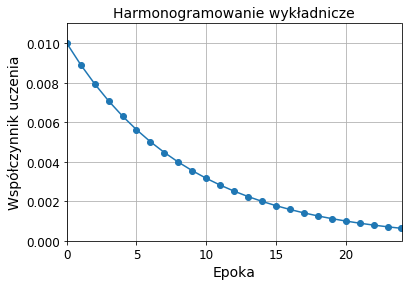

In [82]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoka")
plt.ylabel("Współczynnik uczenia")
plt.title("Harmonogramowanie wykładnicze", fontsize=14)
plt.grid(True)
plt.show()

Funkcja harmonogramowania może przyjmować bieżący współczynnik uczenia jako drugi argument:

In [0]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

Jeżeli chcesz aktualizować współczynnik uczenia w każdej iteracji, a nie epoce, musisz napisać własną klasę wywołania zwrotnego:

In [84]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Uwaga: argument `batch` jest zerowany w każdej epoce
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # liczba kroków w 20 epokach (rozmiar grupy = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 8s 138us/sample - loss: 0.8038 - accuracy: 0.7674 - val_loss: 0.9529 - val_accuracy: 0.7184
Epoch 2/25
55000/55000 [==============================] - 7s 127us/sample - loss: 0.5981 - accuracy: 0.8141 - val_loss: 0.9602 - val_accuracy: 0.7868
Epoch 3/25
55000/55000 [==============================] - 7s 128us/sample - loss: 0.5674 - accuracy: 0.8259 - val_loss: 0.6480 - val_accuracy: 0.8218
Epoch 4/25
55000/55000 [==============================] - 7s 131us/sample - loss: 0.5171 - accuracy: 0.8398 - val_loss: 0.5477 - val_accuracy: 0.8590
Epoch 5/25
55000/55000 [==============================] - 7s 130us/sample - loss: 0.4594 - accuracy: 0.8557 - val_loss: 0.5134 - val_accuracy: 0.8552
Epoch 6/25
55000/55000 [==============================] - 7s 128us/sample - loss: 0.4317 - accuracy: 0.8627 - val_loss: 0.5684 - val_accuracy: 0.8558
Epoch 7/25
55000/55000 [===========================

In [0]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

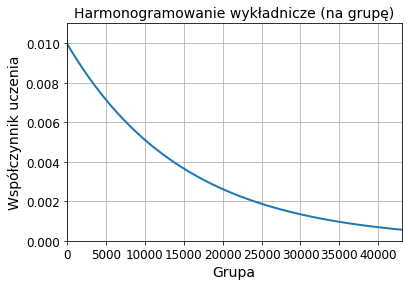

In [86]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Grupa")
plt.ylabel("Współczynnik uczenia")
plt.title("Harmonogramowanie wykładnicze (na grupę)", fontsize=14)
plt.grid(True)
plt.show()

### Harmonogramowanie stałoprzedziałowe

In [0]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [0]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [89]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 6s 113us/sample - loss: 0.8905 - accuracy: 0.7490 - val_loss: 0.8929 - val_accuracy: 0.6694
Epoch 2/25
55000/55000 [==============================] - 6s 103us/sample - loss: 0.9632 - accuracy: 0.7156 - val_loss: 1.0086 - val_accuracy: 0.7116
Epoch 3/25
55000/55000 [==============================] - 6s 103us/sample - loss: 0.9431 - accuracy: 0.6988 - val_loss: 1.2235 - val_accuracy: 0.5034
Epoch 4/25
55000/55000 [==============================] - 6s 104us/sample - loss: 1.0136 - accuracy: 0.6474 - val_loss: 1.0782 - val_accuracy: 0.7018
Epoch 5/25
55000/55000 [==============================] - 6s 110us/sample - loss: 1.0665 - accuracy: 0.6616 - val_loss: 0.9436 - val_accuracy: 0.6874
Epoch 6/25
55000/55000 [==============================] - 6s 104us/sample - loss: 0.7036 - accuracy: 0.7291 - val_loss: 0.8770 - val_accuracy: 0.7408
Epoch 7/25
55000/55000 [===========================

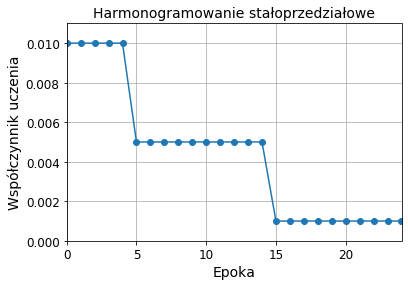

In [90]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoka")
plt.ylabel("Współczynnik uczenia")
plt.title("Harmonogramowanie stałoprzedziałowe", fontsize=14)
plt.grid(True)
plt.show()

### Harmonogramowanie wydajnościowe

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

In [92]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 5s 87us/sample - loss: 0.5931 - accuracy: 0.8070 - val_loss: 0.5156 - val_accuracy: 0.8306
Epoch 2/25
55000/55000 [==============================] - 4s 76us/sample - loss: 0.5110 - accuracy: 0.8352 - val_loss: 0.4789 - val_accuracy: 0.8530
Epoch 3/25
55000/55000 [==============================] - 4s 76us/sample - loss: 0.4956 - accuracy: 0.8458 - val_loss: 0.4735 - val_accuracy: 0.8422
Epoch 4/25
55000/55000 [==============================] - 4s 77us/sample - loss: 0.5197 - accuracy: 0.8463 - val_loss: 0.8011 - val_accuracy: 0.8250
Epoch 5/25
55000/55000 [==============================] - 4s 76us/sample - loss: 0.5178 - accuracy: 0.8513 - val_loss: 0.6040 - val_accuracy: 0.8492
Epoch 6/25
55000/55000 [==============================] - 4s 78us/sample - loss: 0.5007 - accuracy: 0.8550 - val_loss: 0.7717 - val_accuracy: 0.8562
Epoch 7/25
55000/55000 [==============================] -

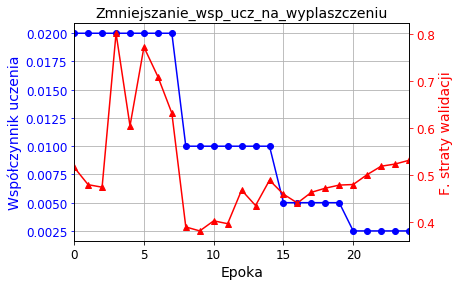

In [93]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoka")
plt.ylabel("Współczynnik uczenia", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('F. straty walidacji', color='r')
ax2.tick_params('y', colors='r')

plt.title("Zmniejszanie_wsp_ucz_na_wyplaszczeniu", fontsize=14)
plt.show()

### Klasa tf.keras schedulers

In [94]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # liczba kroków w 20 epokach (rozmiar grupy = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 4s 82us/sample - loss: 0.4872 - accuracy: 0.8296 - val_loss: 0.4141 - val_accuracy: 0.8548
Epoch 2/25
55000/55000 [==============================] - 4s 77us/sample - loss: 0.3829 - accuracy: 0.8643 - val_loss: 0.3773 - val_accuracy: 0.8704
Epoch 3/25
55000/55000 [==============================] - 4s 78us/sample - loss: 0.3495 - accuracy: 0.8763 - val_loss: 0.3698 - val_accuracy: 0.8730
Epoch 4/25
55000/55000 [==============================] - 4s 76us/sample - loss: 0.3274 - accuracy: 0.8831 - val_loss: 0.3543 - val_accuracy: 0.8756
Epoch 5/25
55000/55000 [==============================] - 4s 78us/sample - loss: 0.3101 - accuracy: 0.8900 - val_loss: 0.3459 - val_accuracy: 0.8788
Epoch 6/25
55000/55000 [==============================] - 4s 79us/sample - loss: 0.2971 - accuracy: 0.8944 - val_loss: 0.3414 - val_accuracy: 0.8798
Epoch 7/25
55000/55000 [==============================] -

Wypróbuj w przypadku harmonogramowania stałoprzedziałowego:

In [0]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

### Harmonogramowanie 1Cycle

In [0]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Współczynnik uczenia")
    plt.ylabel("Funkcja straty")

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

Train on 55000 samples
55000/55000 [==============================] - 2s 34us/sample - loss: nan - accuracy: 0.3936


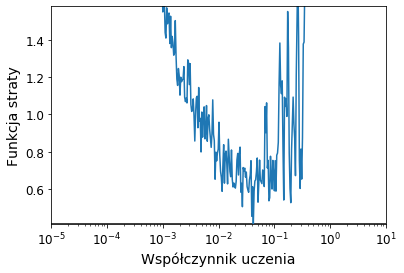

In [98]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [0]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [100]:
n_epochs = 25
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 1s 27us/sample - loss: 0.6576 - accuracy: 0.7743 - val_loss: 0.4901 - val_accuracy: 0.8300
Epoch 2/25
55000/55000 [==============================] - 1s 25us/sample - loss: 0.4587 - accuracy: 0.8387 - val_loss: 0.4317 - val_accuracy: 0.8490
Epoch 3/25
55000/55000 [==============================] - 2s 29us/sample - loss: 0.4119 - accuracy: 0.8561 - val_loss: 0.4118 - val_accuracy: 0.8574
Epoch 4/25
55000/55000 [==============================] - 1s 27us/sample - loss: 0.3842 - accuracy: 0.8658 - val_loss: 0.3922 - val_accuracy: 0.8634
Epoch 5/25
55000/55000 [==============================] - 1s 27us/sample - loss: 0.3636 - accuracy: 0.8711 - val_loss: 0.3740 - val_accuracy: 0.8710
Epoch 6/25
55000/55000 [==============================] - 2s 29us/sample - loss: 0.3460 - accuracy: 0.8768 - val_loss: 0.3740 - val_accuracy: 0.8692
Epoch 7/25
55000/55000 [==============================] -

# Regularyzacja jako sposób na unikanie przetrenowania

## Regularyzacja $\ell_1$ i $\ell_2$

In [0]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# lub l1(0.1) dla regularyzacji ℓ1 o współczynniku 0,1
# lub l1_l2(0.1, 0.01) dla regularyzacji ℓ1 i ℓ2 o współczynnikach, odpowiednio 0,1 i 0,01

In [102]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 7s 121us/sample - loss: 1.5735 - accuracy: 0.8126 - val_loss: 0.7327 - val_accuracy: 0.8222
Epoch 2/2
55000/55000 [==============================] - 6s 114us/sample - loss: 0.7186 - accuracy: 0.8260 - val_loss: 0.6929 - val_accuracy: 0.8338


In [103]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 7s 131us/sample - loss: 1.6006 - accuracy: 0.8129 - val_loss: 0.7374 - val_accuracy: 0.8236
Epoch 2/2
55000/55000 [==============================] - 6s 109us/sample - loss: 0.7179 - accuracy: 0.8265 - val_loss: 0.6905 - val_accuracy: 0.8356


## Porzucanie

In [104]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 7s 120us/sample - loss: 0.5856 - accuracy: 0.7992 - val_loss: 0.3908 - val_accuracy: 0.8570
Epoch 2/2
55000/55000 [==============================] - 6s 110us/sample - loss: 0.4259 - accuracy: 0.8442 - val_loss: 0.3390 - val_accuracy: 0.8730


## Porzucanie alfa

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

In [106]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 5s 92us/sample - loss: 0.6615 - accuracy: 0.7616 - val_loss: 0.6684 - val_accuracy: 0.8252
Epoch 2/20
55000/55000 [==============================] - 5s 84us/sample - loss: 0.5528 - accuracy: 0.7965 - val_loss: 0.5826 - val_accuracy: 0.8386
Epoch 3/20
55000/55000 [==============================] - 5s 87us/sample - loss: 0.5261 - accuracy: 0.8063 - val_loss: 0.5313 - val_accuracy: 0.8536
Epoch 4/20
55000/55000 [==============================] - 5s 87us/sample - loss: 0.5076 - accuracy: 0.8110 - val_loss: 0.4884 - val_accuracy: 0.8640
Epoch 5/20
55000/55000 [==============================] - 5s 84us/sample - loss: 0.4931 - accuracy: 0.8179 - val_loss: 0.4963 - val_accuracy: 0.8588
Epoch 6/20
55000/55000 [==============================] - 5s 85us/sample - loss: 0.4837 - accuracy: 0.8199 - val_loss: 0.5083 - val_accuracy: 0.8528
Epoch 7/20
55000/55000 [==============================] -

In [107]:
model.evaluate(X_test_scaled, y_test)

10000/10000 [==============================] - 1s 58us/sample - loss: 0.4723 - accuracy: 0.8669


[0.4723118964552879, 0.8669]

In [108]:
model.evaluate(X_train_scaled, y_train)

55000/55000 [==============================] - 3s 59us/sample - loss: 0.3474 - accuracy: 0.8862


[0.34736757821494885, 0.8862182]

In [109]:
history = model.fit(X_train_scaled, y_train)

Train on 55000 samples
55000/55000 [==============================] - 4s 82us/sample - loss: 0.4201 - accuracy: 0.8450


## Porzucanie metodą Monte Carlo

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

In [111]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [112]:
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [113]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.1 , 0.  , 0.89]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.15, 0.  , 0.12, 0.  , 0.73]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.13, 0.  , 0.03, 0.  , 0.84]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.02, 0.03, 0.93]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.03, 0.  , 0.92]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.07, 0.  , 0.92]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.97]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.73, 0.  , 0.02, 0.  , 0.24]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.98]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.  , 0.04, 0.  , 0.91]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.2 , 0.  , 0.04, 0.  , 0.76]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.46, 0.  , 0.08, 0.  , 0.46]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.32, 0.  , 0.12, 0.  , 0

In [114]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.12, 0.  , 0.06, 0.  , 0.82]],
      dtype=float32)

In [115]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.2 , 0.  , 0.09, 0.01, 0.22]],
      dtype=float32)

In [0]:
y_pred = np.argmax(y_proba, axis=1)

In [117]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8596

In [0]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

In [0]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [121]:
mc_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_18 (Flatten)         (None, 784)               0         
_________________________________________________________________
mc_alpha_dropout (MCAlphaDro (None, 784)               0         
_________________________________________________________________
dense_262 (Dense)            (None, 300)               235500    
_________________________________________________________________
mc_alpha_dropout_1 (MCAlphaD (None, 300)               0         
_________________________________________________________________
dense_263 (Dense)            (None, 100)               30100     
_________________________________________________________________
mc_alpha_dropout_2 (MCAlphaD (None, 100)               0         
_________________________________________________________________
dense_264 (Dense)            (None, 10)              

In [0]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [0]:
mc_model.set_weights(model.get_weights())

Możemy teraz użyć modelu z porzucaniem MC:

In [124]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.13, 0.  , 0.08, 0.  , 0.79]],
      dtype=float32)

## Regularyzacja typu max-norm

In [0]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [126]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 7s 120us/sample - loss: 0.4745 - accuracy: 0.8353 - val_loss: 0.4015 - val_accuracy: 0.8592
Epoch 2/2
55000/55000 [==============================] - 6s 109us/sample - loss: 0.3570 - accuracy: 0.8677 - val_loss: 0.3558 - val_accuracy: 0.8748


# Ćwiczenia

## 1. do 7.

Zobacz dodatek A.

## 8. Potrenuj uczenie głębokiej sieci neuronowej na zestawie obrazów CIFAR10

### 8.1.

_Ćwiczenie: Stwórz sieć głęboką zawierającą 20 warstw ukrytych po 100 neuronów w każdej (jest ich za dużo, ale taki jest morał tego ćwiczenia). Skorzystaj z inicjalizacji He i funkcji aktywacji ELU._

### 8.2.

_Ćwiczenie: Wprowadź optymalizację Nadam i wczesne zatrzymywanie, po czym wyucz sieć na zestawie danych CIFAR10.  Możesz go wczytać za pomocą funkcji `keras.datasets.cifar10.load_data()`. Zestaw ten składa się z 60 000 kolorowych obrazów (50 000 przykładów uczących i 10 000 testowych) o rozmiarach 32 × 32, tworzących 10 klas, co oznacza, że będziesz musiał w warstwie wyjściowej wprowadzić funkcję softmax i 10 neuronów. Pamiętaj, aby po każdej zmianie struktury lub hiperparametrów modelu poszukać właściwej wartości współczynnika uczenia._

### 8.3.

_Ćwiczenie: Spróbuj teraz dodać normalizację wsadową i porównać współczynniki uczenia. Czy model uzyskuje teraz szybciej zbieżność? Czy otrzymany model jest lepszy? Co się dzieje z szybkością uczenia?_

### 8.4.

_Ćwiczenie: Zastąp teraz normalizację wsadową funkcją SELU i wprowadź wszelkie modyfikacje wymagane to spełnienia wymogu samonormalizacji (tj. standaryzuj cechy wejściowe, skorzystać z klasycznej inicjalizacji LeCuna, upewnij się, że sieć głęboka będzie zawierała wyłącznie sekwencję warstw gęstych itd.)._

### 8.5.

_Ćwiczenie: Spróbuj przeprowadzić regularyzację modelu za pomocą porzucania alfa. Następnie sprawdź, czy możesz uzyskać lepszą wydajność za pomocą porzucania MC bez trenowania modelu._

### 8.6.

_Ćwiczenie: Wytrenuj ponownie model za pomocą harmonogramowania 1cycle i sprawdź, jaki ma ono wpływ na szybkość uczenia i dokładność modelu._